---
### **<p style="text-align: center; text-decoration: underline;">Introduction to GCNs</p>**
# **<p style="text-align: center;">Graph Convolutional Networks (GCNs) for ENZYMES Recognition</p>**
---

> Tutor: *Omar Ikne*.

> Master 1 & 2, IMT Nord Europe.

---

### ■ __Overview__
In this notebook, we will investigate the utilization of Graph Convolutional Networks (GCNs) for enzymes recognition. Specifically, we aim to classify different enzymes using graph representations. The fundamental concept involves using the capabilities of GCNs to extract insightful features from different enzymes and subsequently classify each gesture individually.

The main task of this lab is to build a graph-based deep learning model to recognize the enzymes (figure bellow).
#### **Main Task: Enzymes Recognition**
![Alt text](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fvignette.wikia.nocookie.net%2Fanalytical%2Fimages%2F3%2F34%2FEnzyme.jpg%2Frevision%2Flatest%3Fcb%3D20100726084438&f=1&nofb=1&ipt=465540306a176092f491ff8a13c31f9611fcd39d7ba0e5b61e8e167b4486a4f8&ipo=images "Enzymes")

### ■ **<a name="content">Contents</a>**

- [1. Preliminaries](#section1)

- [1. Enzymes Dataset](#section2)

- [2. GCN Model](#section3)

- [3. Model Training](#section4)

- [4. Model Evaluation](#section5)

- [5. Demo](#section6)

In [1]:
## download the dataset
#!pip uninstall gdown -y && pip install gdown


### ■ **Libraries**

In [2]:
!pip install torch
!pip install torch_geometric
!pip install networkx


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
## torch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as transforms
import torch.optim as optim

## basic dependencies from math and visualization
import networkx as nx
import numpy as np
import random
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from copy import deepcopy

In [4]:
def seed_everything(seed=51):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

### ■ **<a name="pre">1. Preliminaries</a>** [(&#8593;)](#content)
The ENZYMES dataset is commonly used as a benchmark dataset in the field of graph classification, particularly for evaluating the performance of graph-based machine learning models, including Graph Convolutional Networks (GCNs). 
ENZYMES is a dataset of protein tertiary structures obtained from (Borgwardt et al., 2005) consisting of 600 enzymes from the BRENDA enzyme database (Schomburg et al., 2004). In this case the task is to correctly assign each enzyme to one of the 6 EC top-level classes.
Below is a general description of the ENZYMES dataset:

#### `ENZYMES Dataset:`

1. **Source:**
   - The ENZYMES dataset is often used in the context of graph classification tasks.
   - It is part of the TU Dortmund University Graph Database ([TUDataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.TUDataset.html#torch_geometric.datasets.TUDataset)).

2. **Graphs:**
   - Each graph in the dataset represents the 3D structure of a protein.
   - Nodes in the graph represent amino acids, and edges represent interactions between amino acids.

3. **Labels:**
   - The dataset is typically used for graph classification, where each graph is associated with a class label.
   - Class labels represent different enzyme classes or families.

4. **Tasks:**
   - The primary task associated with the ENZYMES dataset is graph classification.
   - The goal is to train a model to predict the enzyme class or family based on the graph representation of the protein's 3D structure.

5. **Graph Properties:**
   - The graphs are heterogeneous and vary in terms of the number of nodes and edges.
   - Each graph captures the structural information of a different protein, making it suitable for evaluating models' ability to generalize to diverse graph structures.

6. **Dataset Size:**
   - The ENZYMES dataset typically consists of a moderate number of graphs, with each graph corresponding to a unique protein structure.

7. **Use in Research:**
   - Researchers often use the ENZYMES dataset to assess the performance of graph-based machine learning models, especially graph classification algorithms like GCNs.

8. **Availability:**
   - The ENZYMES dataset is publicly available and can be accessed through graph database [TUDataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.TUDataset.html#torch_geometric.datasets.TUDataset).


![Alt text](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimage3.slideserve.com%2F6898777%2Fenzyme-and-protein-structure-l.jpg&f=1&nofb=1&ipt=81702931cf27e65b54827ac537d59f70610c91ecc48d8b8172cff0664ee9e345&ipo=images "Enzyme Structure")

#### **Dataset Overview**

In [5]:
## load dataset
dataset = TUDataset('./', 'ENZYMES')
# Print information
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

ENZYMES(600)
------------
Number of graphs: 600
Number of features: 3
Number of classes: 6


/home/omar/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:4347: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  c = np.asanyarray(c, dtype=float)


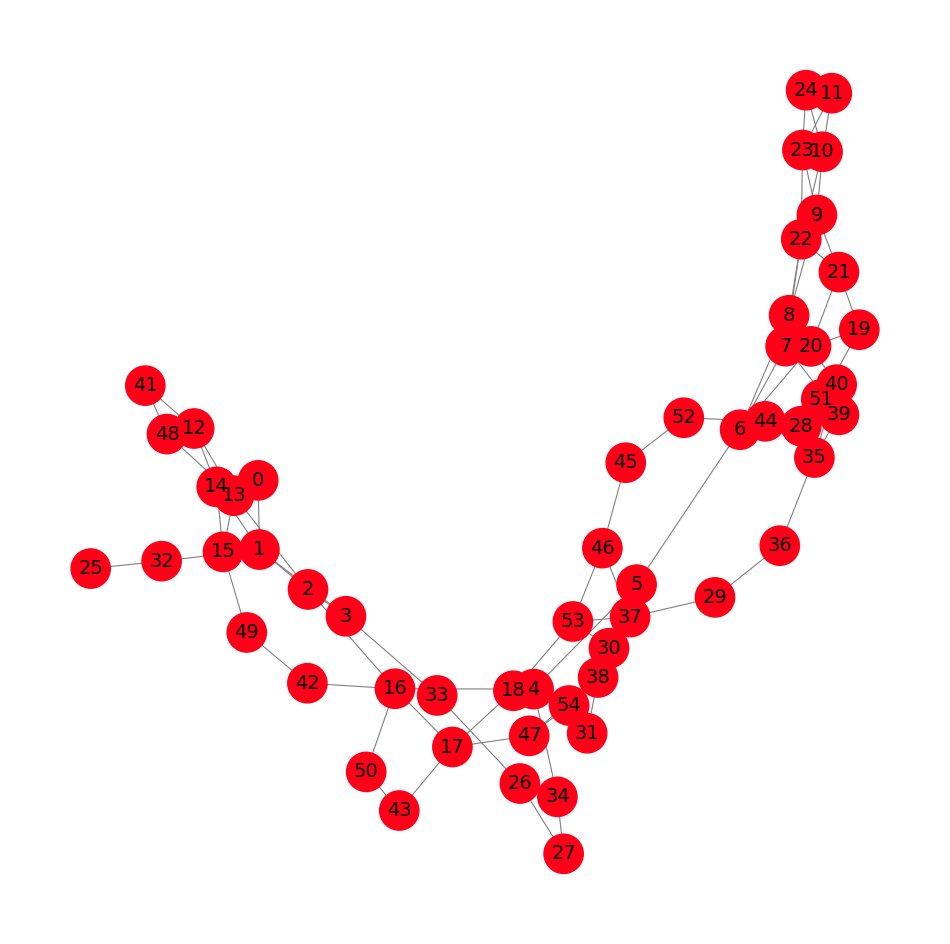

In [6]:
from torch_geometric.utils import to_networkx

data = dataset[15].detach()
data.y = [data.y] * len(data.x)
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

### ■ **<a name="dataset">2. Dataset</a>** [(&#8593;)](#content)
In this second section, our focus shifts to creating the dataset essential for training the Graph Convolutional Network (GCN). The dataset is designed to provide different enzymes, the corresponding adjacency matrices (here encoded by an edge indices map), and the associated sign labels.

#### **2.2 Define the dataset**

In [9]:
class EnzymesDataModule(nn.Module):
    def __init__(
        self,
        data_dir="/data/",
        batch_size=64,
        num_workers=0,
        splits=[0.7, 0.15, 0.15],
        seed=51,
    ):
        super(EnzymesDataModule, self).__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.splits = splits
        self.seed = seed
        self.transform = transforms.Compose(
            [
                transforms.NormalizeFeatures(),
            ]
        )

        # Number of graphs, classes and features
        self.num_graphs = 600
        self.num_classes = 6
        self.num_features = 21

    def prepare_data(self):
        # Download data
        TUDataset(
            root=self.data_dir,
            name="ENZYMES",
            use_node_attr=True,
            use_edge_attr=True,
            transform=None,
            pre_transform=self.transform,
        )

    def setup(self, stage=None):
        initial_seed = torch.initial_seed()
        torch.manual_seed(self.seed)
        dataset = TUDataset(
            root=self.data_dir,
            name="ENZYMES",
            use_node_attr=True,
            use_edge_attr=True,
            pre_transform=self.transform,
        ).shuffle()

        split_idx = np.cumsum(
            [int(len(dataset) * prop) for prop in self.splits])
        self.data_train = dataset[: split_idx[0]]
        self.data_val = dataset[split_idx[0]: split_idx[1]]
        self.data_test = dataset[split_idx[1]:]
        torch.manual_seed(initial_seed)

    def train_dataloader(self):
        return DataLoader(
            self.data_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.data_val,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True,
        )
    
    def eval_dataloader(self):
        return DataLoader(
            self.data_val,
            batch_size=1,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )
    

In [10]:
batch_size = 32
dm = EnzymesDataModule(data_dir="./",
                       batch_size=batch_size,
                       splits=[0.8, 0.2])

dm.prepare_data()
dm.setup()

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

## stats
print('The number of training batches   :', len(train_loader))
print('The number of validation batches :', len(val_loader))

The number of training batches   : 15
The number of validation batches : 4


/home/omar/anaconda3/envs/Torch/lib/python3.10/site-packages/torch_geometric/data/dataset.py:190: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, make sure to delete './ENZYMES/processed' first
  warnings.warn(


In [11]:
## check that the loaders work well by extracting an element from the laoder.
## out is a dictionary that contains a batch data from the loader.
## out contains: Hand_pose -> shape(batch_size, 21, 3), Adjacency_matrix -> shape (batch_size, 21, 21), Label -> shape (batch_size)
out = next(iter(train_loader))
out

DataBatch(edge_index=[2, 3504], x=[918, 21], y=[32], batch=[918], ptr=[33])

Here we do some data analysis by ploting the number of samples per class. This allows us to see whether the data is balanced or not !

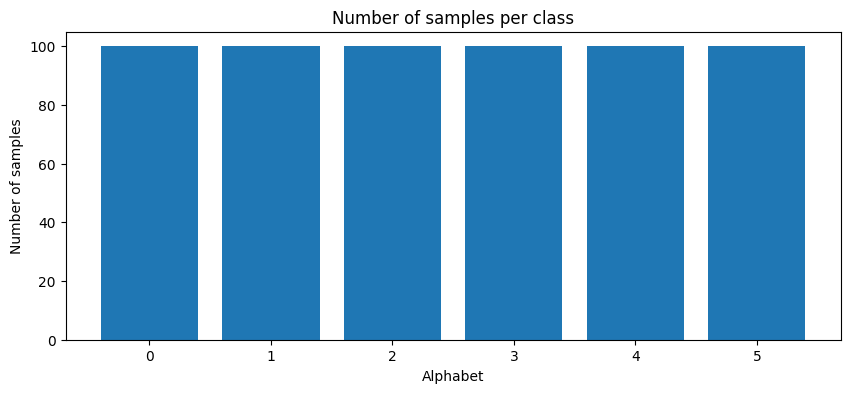

In [12]:
## plot the number of samples per class
values, counts = np.unique(dataset.data.y.numpy(), return_counts=True)

plt.figure(figsize=(10, 4))
plt.bar(values, counts)
plt.title('Number of samples per class')
plt.xlabel('Alphabet')
plt.ylabel('Number of samples')
plt.show()

#### **Adjacency Matrix**

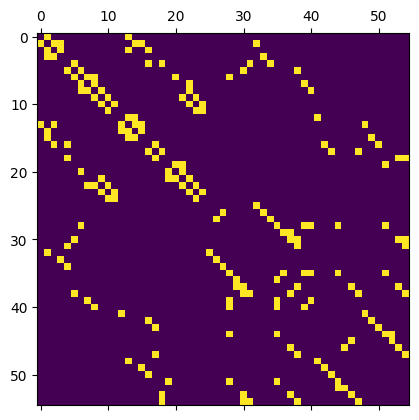

In [7]:
from torch_geometric.utils import to_dense_adj

adjacency_matrix = to_dense_adj(data.edge_index)[0]
plt.matshow(adjacency_matrix)

### **Distribution of the number of nodes in enzymes in the dataset**

Text(0.5, 1.0, 'Distribution of the number of nodes in enzymes in the dataset')

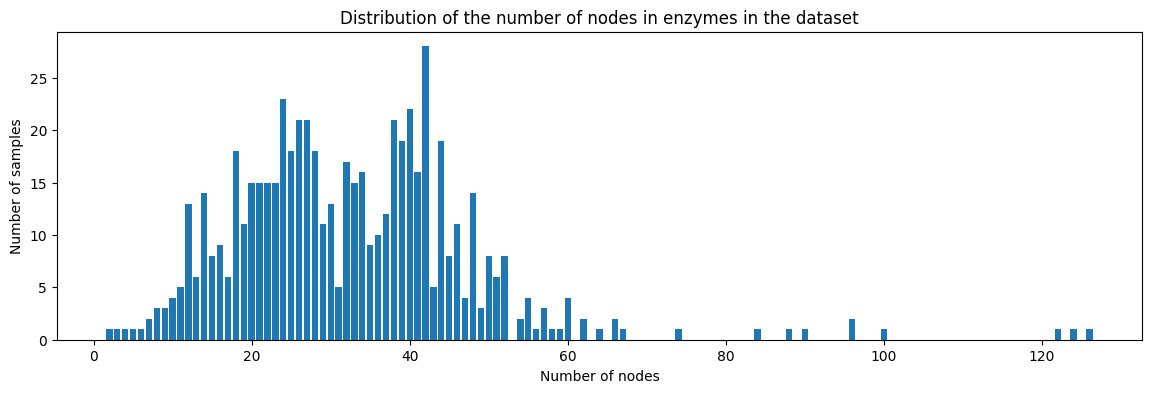

In [29]:
plt.figure(figsize=(14, 4))
plt.bar(*np.unique([d.num_nodes for d in dataset], return_counts=True))
plt.xlabel('Number of nodes')
plt.ylabel('Number of samples')
plt.title('Distribution of the number of nodes in enzymes in the dataset')

### ■ **<a name="model">3. GCN Model</a>** [(&#8593;)](#content)
No that the dataloaders are ready, we can build our GCN model to classify enzymes ! We start by defining the Graph Convolution Layer.

#### **GCN module**
Now we define the GCN model by stacking a set of GCN layers to extract features, and an MLP layer to classify the extracted features into different classes.

In [30]:
from torch_geometric.nn import (GCNConv, global_add_pool, global_max_pool,
                                global_mean_pool)


class GCN(nn.Module):
    def __init__(
        self,
        n_node_features: int,
        n_classes: int,
        conv_channels: int = 32,
        fc_size: int = 32,
        global_pooling = global_mean_pool,
        activation = nn.LeakyReLU,
        dropout: float = 0.15,
    ):
        super(GCN, self).__init__()
        self.n_node_features = n_node_features
        self.n_classes = n_classes
        self.conv_channels = conv_channels
        self.fc_size = fc_size
        self.activation = activation()
        self.dropout = dropout

        self.gcn1 = GCNConv(
            in_channels=self.n_node_features,
            out_channels=self.conv_channels,
            normalize=True,
        )
        self.gcn2 = GCNConv(
            in_channels=self.conv_channels,
            out_channels=self.conv_channels,
            normalize=True,
        )

        
        self.fc1 = nn.Linear(
            in_features=self.conv_channels, out_features=self.fc_size)
        self.fc2 = nn.Linear(
            in_features=self.fc_size, out_features=self.n_classes)


        self.global_pooling = global_pooling
        self.dropout = nn.Dropout(p=self.dropout)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, batch: torch.Tensor):
        # Check input dimension
        if x.shape[1] != self.n_node_features:
            raise ValueError(
                f"Number of node features of input x is correct. "
                f"Expected {self.n_node_features} but got {x.shape[1]}."
            )
        if batch.shape[0] != x.shape[0]:
            raise ValueError(
                "Number of nodes in x is incompatible with number of nodes "
                "in batch."
            )

        # Perform message passing
        x = self.activation(self.gcn1(x, edge_index))  # [nodes_batch, hidden]
        x = self.gcn2(x, edge_index)  # [nodes_in_batch, hidden_size]
        
        # Apply global pooling layer
        embed = self.global_pooling(x, batch)  # [batch_size, hidden_size]
        
        # Feed through linear layer for prediction
        embed = self.dropout(self.activation(self.fc1(embed)))  # [batch_size, hidden_size]
        embed = self.fc2(embed)  # [batch_size, n_classes]

        return embed

### ■ **<a name="train">4. Model Training</a>** [(&#8593;)](#content)
We are now ready to train our model. We define a `train_epoch` function to train our model for one epoch.

In [14]:
def train_epoch(epoch, num_epochs, model, optimizer, dataloader, device, criterion, scheduler=None):
    """
    to train the model for one epoch !
    Params:
    ======
        - epoch: current epoch,
        - num_epochs: total number of epochs,
        - model: model to train,
        - optimizer: optimizer to optimize the loss of the model,
        - dataloader: the training data laoder.
        - device: cpu or gpu,
        - criterion: the loss function: crossentropy,
        - sheduler[defualt=None]: if any to adjust the learning rate of the optimizer.
    """

    ## make the model in train mode
    model.train()

    ## create a progression bar to display the progression of training
    pbar = tqdm(dataloader, total=len(dataloader))
    total_loss = 0

    ## for each batch
    for batch in pbar:
        ## get data from the batch
        batch = batch.to(device)

        ## predict and calculate the loss on the given batch, and optimize the loss accordingly
        optimizer.zero_grad()
        pred = model(batch.x, batch.edge_index, batch.batch)
        loss_train = criterion(pred, batch.y)
        loss_train.backward()
        optimizer.step()

        total_loss += loss_train.item()
        ## set the discription bar
        pbar.set_description(f'[%.3g/%.3g] train loss. %.3f' % (epoch, num_epochs, total_loss/len(batch.y)))

    if scheduler is not None:
        scheduler.step()

    return total_loss


def validate_epoch(model, dataloader, criterion):
    """to evaluate the model !
    Params:
    ======
        - model: model to evaluate,
        - dataloader: the testing data laoder.
        - criterion: the loss function to calculate the validation loss,
    """

    acc = 0.0
    n = 0
    pred_labels, true_labels = [], []
    total_loss = 0.0

    ## turn the model into evaluation mode
    model.eval()

    ## no need to compute grads in validation stage, this makes the process run fast
    with torch.no_grad():
        pbar = tqdm(dataloader, total=len(dataloader))

        for batch in pbar:
            batch = batch.to(device)

            pred = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(pred, batch.y)

            ## calculate accuracy
            acc += (pred.argmax(dim=1) == batch.y.flatten()).sum().item()
            n += len(batch.y.flatten())

            total_loss += loss.item()

            true_labels.extend(batch.y.tolist())
            pred_labels.extend(pred.argmax(dim=1).tolist())

            desc = '[VALID]> loss. %.2f > acc. %.2g%%' % (total_loss/len(batch.y), (acc / n)*100)
            pbar.set_description(desc)

    accuracy = acc / n

    return total_loss, accuracy, true_labels, pred_labels

In [15]:
## model parameters
n_node_features = 21
conv_channels = 128
n_classes = 6
fc_size = 256
dropout = 0.15

activation = nn.GELU # in [nn.ReLU, nn.LeakyReLU, nn.GELU, etc]
global_pooling = global_mean_pool # in [global_add_pool, global_max_pool, global_mean_pool]

## device: cpu / gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('available device:', device)

## build model
model = GCN(n_node_features=n_node_features,
            n_classes=n_classes,
            conv_channels=conv_channels,
            fc_size=fc_size,
            global_pooling=global_pooling,
            activation=activation,
            dropout=dropout)


## trainig parameters
lr = 1e-3
weight_decay = 5e-2
num_epochs = 500

## create optimizer, schedular and loss function
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0, last_epoch=-1, verbose=False)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

## put model into device
model = nn.DataParallel(model).to(device)

# Training loop
valid_accuracies = []
valid_losses = []

best_preds = None
best_acc = 0.0
best_model = model

for epoch in range(1, num_epochs+1):
    train_loss = train_epoch(epoch, num_epochs, model, optimizer, train_loader, device, criterion)
    valid_loss, val_acc, true_labels, pred_labels = validate_epoch(model, val_loader, criterion)

    valid_accuracies.append(val_acc * 100)
    valid_losses.append(valid_loss)
    
    if best_acc < val_acc:
        best_preds = pred_labels
        best_acc = val_acc
        best_model = deepcopy(model)

available device: cpu


[VALID]> loss. 0.27 > acc. 64%: 100%|████████████| 4/4 [00:00<00:00, 136.44it/s]


### ■ **<a name="eval">4. Model Evaluation</a>** [(&#8593;)](#content)
Now we evaluate our trained model. We plot both the validation loss and accuracy. We also plot the confusion matrix for different classes.

The best validation accuracy: 70.0%


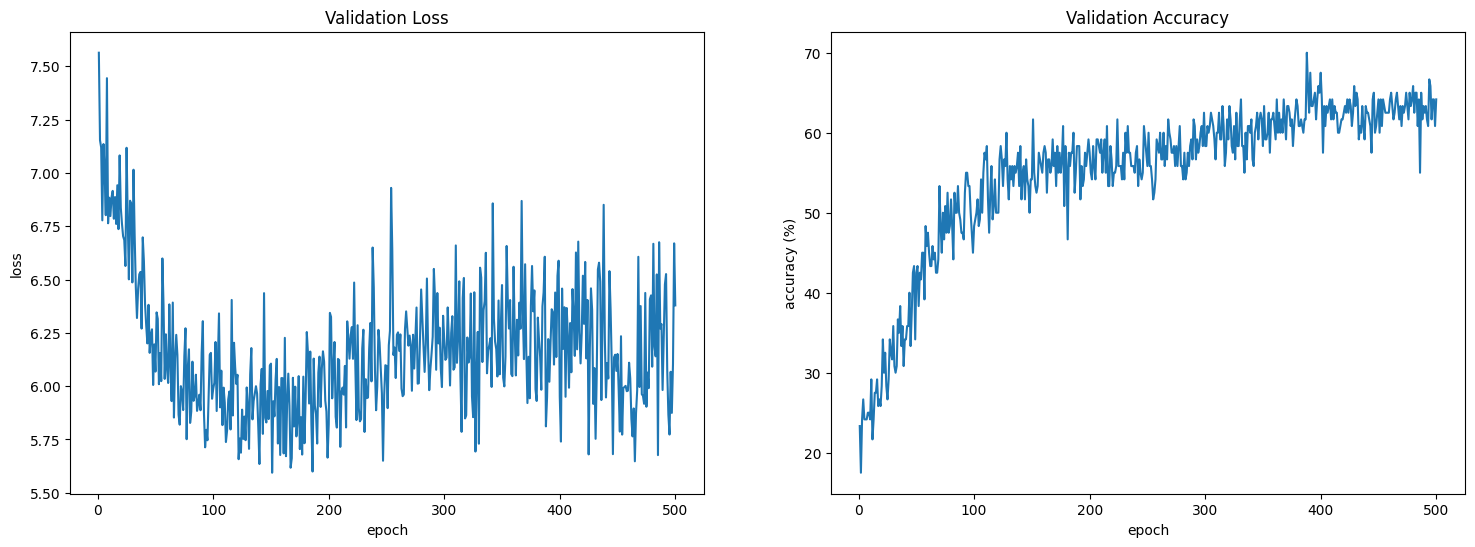

In [31]:
print(f'The best validation accuracy: {round(best_acc * 100, 2)}%')

## display validation loss and accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

## loss
ax1.plot(range(1, num_epochs+1), valid_losses)
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_title('Validation Loss')

## accuracy
ax2.plot(range(1, num_epochs+1), valid_accuracies)
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy (%)')
ax2.set_title('Validation Accuracy')

plt.show()

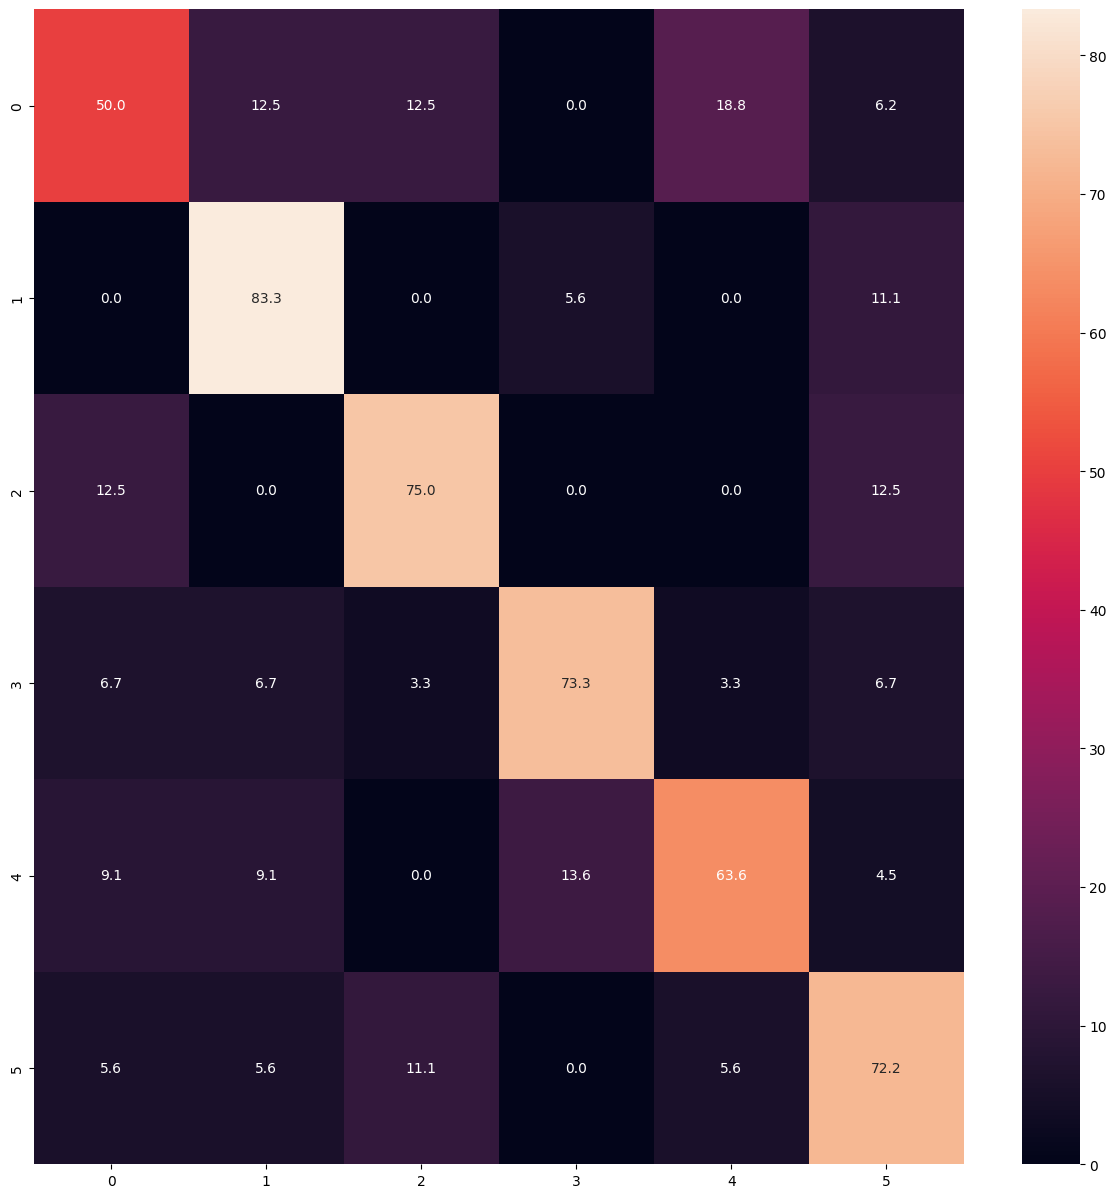

In [32]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(confusion_matrix(true_labels, best_preds, normalize='true')*100, ax=ax, annot=True, fmt='.1f')
plt.show()

### ■ **<a name="demo">4. Demo</a>** [(&#8593;)](#content)
You now test the model on any given  image. You can also try your own image. An interesting perspective is to build a real time Alphabet recognition to communicate with the computer !

In [33]:
def plot_prediction_probability(probas):
    """plots the prediction confidence across classes !"""
    fig, ax = plt.subplots(figsize=(10, 4))
    x = np.arange(n_classes)

    ax.bar(x, probas, width=0.2, color='b', align='center', alpha=0.8)
    ax.set_xlabel('Class')
    ax.set_ylabel('Probability')
    ax.set_title('Prediction Probability Distribution')
    plt.show()

def enzym_recognition_demo(model, enzym_data):
    """Predicts the enzym class given an enzym data, and a trained model !"""

    ## display enzym
    G = to_networkx(enzym_data, to_undirected=True)
    plt.figure(figsize=(12,12))
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=[enzym_data.y] * len(enzym_data.x),
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.show()

    ## put model in mode evaluation
    model.eval()

    ## predict
    enzym_data = enzym_data.to(device)
    pred = model(enzym_data.x, enzym_data.edge_index, enzym_data.batch)
    probas = F.softmax(pred, dim=1)
    pred_labels = probas.argmax(dim=1)
    
    ## print results
    print('\t> True label     :', enzym_data.y.item())
    print('\t> Predicted label:', pred_labels.item(), '| Probability:', round(probas[0].max().item(), 2))

    ## plot prediction probability
    plot_prediction_probability(probas[0].detach().numpy())

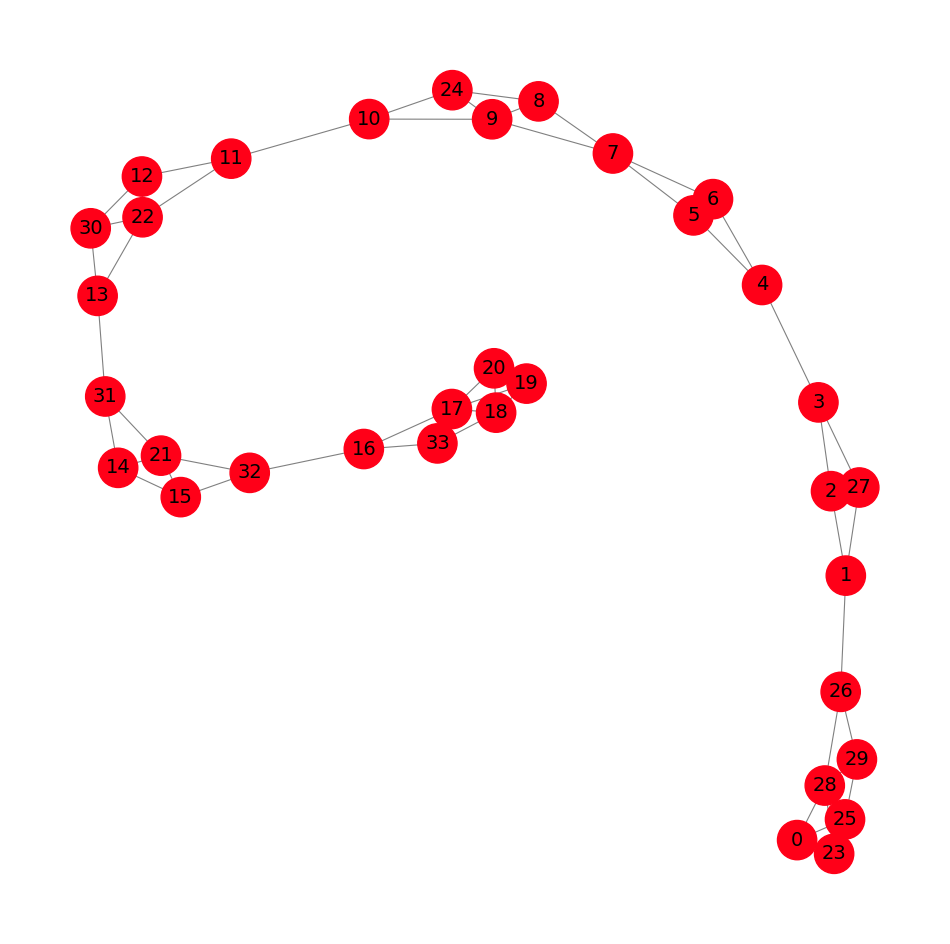

	> True label     : 5
	> Predicted label: 5 | Probability: 0.6


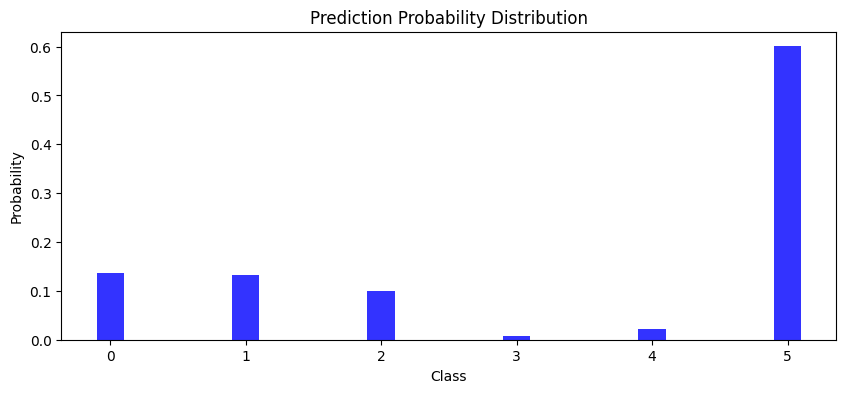

In [47]:
## get evaluation loader
eval_loader = dm.eval_dataloader()

## pick an enzym
enzym_data = next(iter(eval_loader))

## get the prediction
enzym_recognition_demo(model, enzym_data)

---
<p style="text-align: center;">Copyright © 2023 Omar Ikne</p>